In [14]:
import numpy as np
import pandas_datareader as web
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import yfinance as yf

In [15]:
# using JD as its not as stable
df=yf.download('AAPL', start='2015-07-01', end='2023-07-01')
df.head()


[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2015-07-01,31.725000,31.735001,31.497499,31.650000,28.599466,120955200
2015-07-02,31.607500,31.672501,31.442499,31.610001,28.563326,108844000
2015-07-06,31.235001,31.557501,31.212500,31.500000,28.463930,112241600
2015-07-07,31.472500,31.537500,30.942499,31.422501,28.393898,187787200
2015-07-08,31.120001,31.160000,30.635000,30.642500,27.689079,243046400


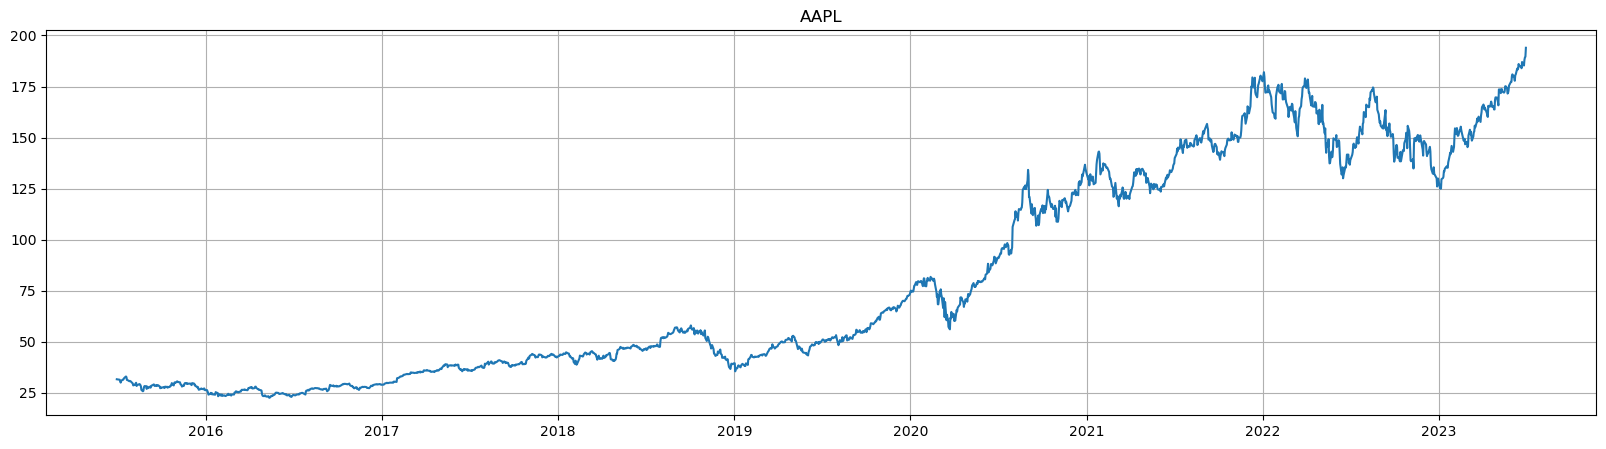

In [16]:
plt.figure(figsize=(20,5))
plt.plot(df.Close)
plt.title("AAPL")
plt.grid()

In [17]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0,0.75))
# 0.75 so it's easier for relu to reach

# closing valueŝ
ser = df.Close.values
ser = ser.reshape(-1,1)
# scaled series
series = scaler.fit_transform(ser)

In [18]:
int(series.shape[0]*0.9)

1812

In [19]:
# fixed input size to model, last 30 days
Window = 30
Predday = 7

# To split the data into 90:10
Trainsplit = 0.9

cut = int(series.shape[0]*Trainsplit)

# train
closetrain = series[:cut]
# test
closetest = series[cut:-(Window+Predday)]
# forecast for future 7 days
closeforecast = series[-(Window+Predday):]

closetrain.shape, closetest.shape , closeforecast.shape

((1812, 1), (165, 1), (37, 1))

In [20]:
def windowed_dataset(series, window_size = 31,predday = 7, batch_size = 32, shuffle_buffer= 1000):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + predday, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + predday))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-7], tf.squeeze(w[-7:])))
    return ds.batch(batch_size).prefetch(3)

trainbatches =  windowed_dataset(closetrain)
testbatches =  windowed_dataset(closetest,batch_size=8)


In [21]:
testbatches

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, None, 1), dtype=tf.float64, name=None), TensorSpec(shape=<unknown>, dtype=tf.float64, name=None))>

In [22]:
# from google.colab import drive
# drive.mount('/content/drive')


In [26]:
from tensorflow.keras.models import load_model
path=r'C:\Users\djsma\Downloads\DSC_Stock\Experiments NB\Model1_pred_7days.h5'
new_model=load_model(path)
new_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, None, 128)         768       
                                                                 
 lstm (LSTM)                 (None, None, 128)         131584    
                                                                 
 lstm_1 (LSTM)               (None, None, 128)         131584    
                                                                 
 lstm_2 (LSTM)               (None, 128)               131584    
                                                                 
 dense (Dense)               (None, 64)                8256      
                                                                 
 dense_1 (Dense)             (None, 64)                4160      
                                                                 
 dense_2 (Dense)             (None, 7)                 4

In [28]:
h = new_model.fit(trainbatches,epochs=10,validation_data=testbatches,verbose=1)
hist = h.history

Epoch 1/10


56/56 [==============================] - 7s 115ms/step - loss: 1.0923e-04 - mse: 2.1846e-04 - val_loss: 2.5454e-04 - val_mse: 5.0908e-04
Epoch 2/10
56/56 [==============================] - 7s 114ms/step - loss: 1.0755e-04 - mse: 2.1510e-04 - val_loss: 4.8540e-04 - val_mse: 9.7080e-04
Epoch 3/10
56/56 [==============================] - 7s 113ms/step - loss: 1.4243e-04 - mse: 2.8486e-04 - val_loss: 2.7936e-04 - val_mse: 5.5871e-04
Epoch 4/10
56/56 [==============================] - 6s 110ms/step - loss: 1.3091e-04 - mse: 2.6182e-04 - val_loss: 2.6480e-04 - val_mse: 5.2960e-04
Epoch 5/10
56/56 [==============================] - 6s 110ms/step - loss: 1.6493e-04 - mse: 3.2986e-04 - val_loss: 2.7725e-04 - val_mse: 5.5449e-04
Epoch 6/10
56/56 [==============================] - 6s 112ms/step - loss: 1.4027e-04 - mse: 2.8054e-04 - val_loss: 2.8745e-04 - val_mse: 5.7490e-04
Epoch 7/10
56/56 [==============================] - 6s 111ms/step - loss: 1.4515e-04 - mse: 2.9030e-04 - val_loss: 2.5703e-

In [29]:
hist.keys()

dict_keys(['loss', 'mse', 'val_loss', 'val_mse'])

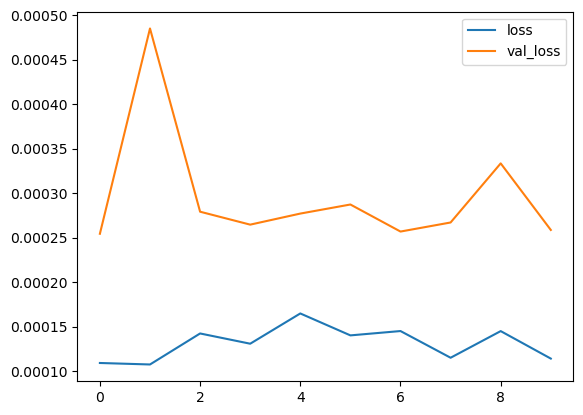

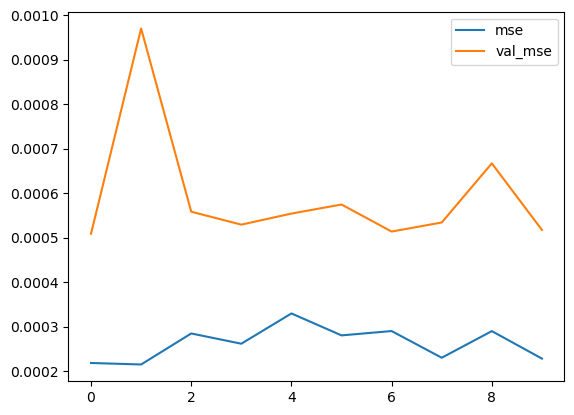

In [31]:
for i in ["loss","mse"]:
    plt.plot(hist[i],label = i)
    plt.plot(hist["val_"+i],label = "val_"+i)
    plt.legend()
    plt.show()


In [32]:
x1,y1 = next(iter(testbatches))
output = new_model.predict(x1)
output.shape

1/1 [==============================] - 2s 2s/step


(8, 7)

In [33]:
testbatches

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, None, 1), dtype=tf.float64, name=None), TensorSpec(shape=<unknown>, dtype=tf.float64, name=None))>

1/1 [==============================] - 0s 80ms/step


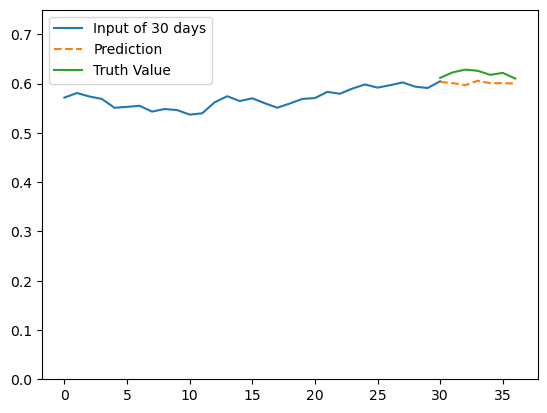

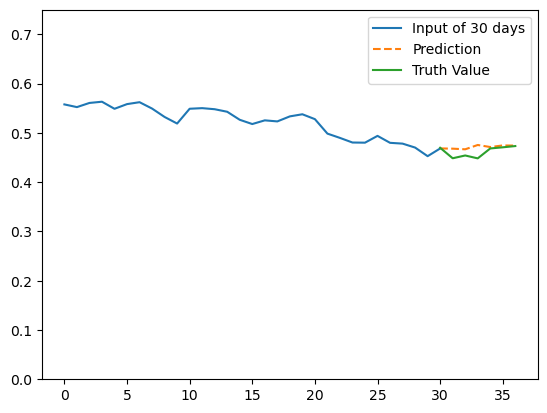

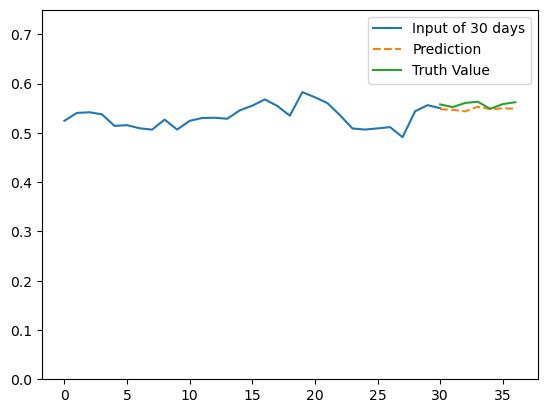

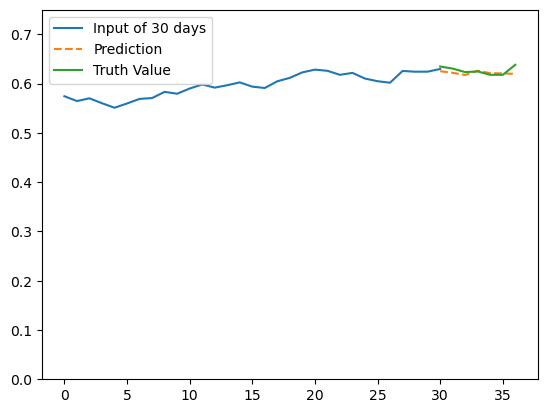

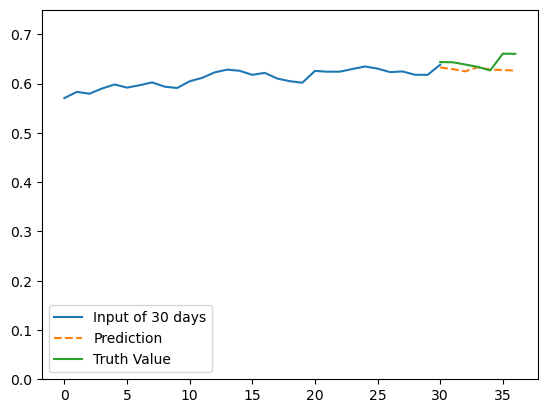

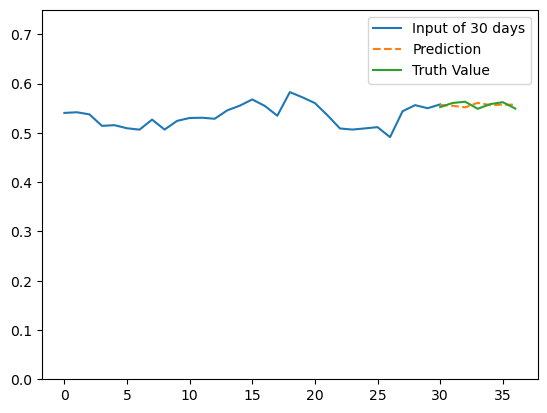

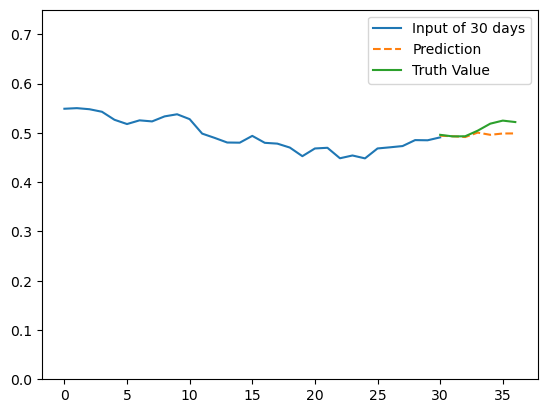

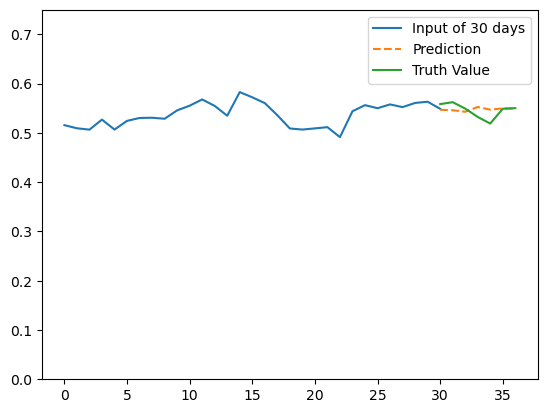

In [34]:
def visualplotloss(dataset):
    x,y = next(iter(dataset))
    output = new_model.predict(x)
    timecorr =list(range(30,37))
    for j in range(8):
        plt.ylim(0,0.75)
        plt.plot(x[j])
        plt.plot(timecorr,output[j],"--")
        plt.plot(timecorr,y[j])
        plt.legend(["Input of 30 days","Prediction","Truth Value"])
        plt.show()

visualplotloss(testbatches)

In [35]:
new_model.evaluate(testbatches)

16/16 [==============================] - 0s 25ms/step - loss: 2.5883e-04 - mse: 5.1767e-04


[0.0002588330244179815, 0.000517666048835963]

1/1 [==============================] - 0s 52ms/step


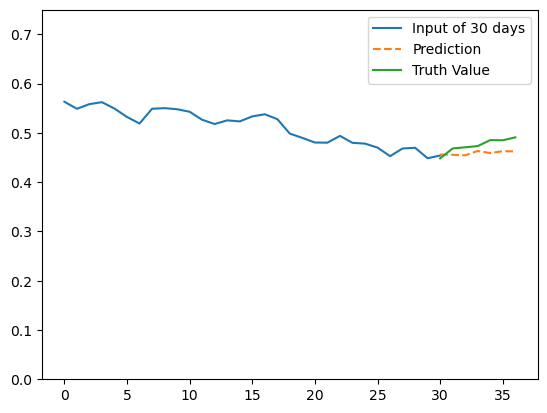

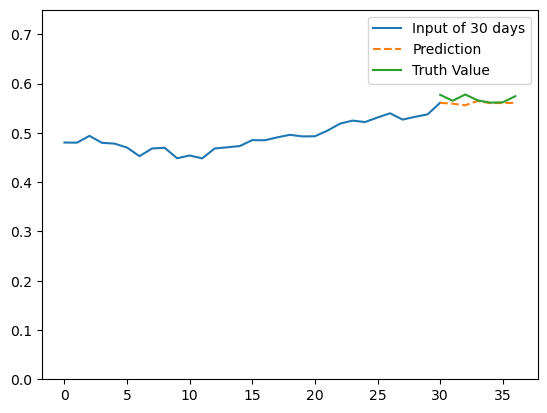

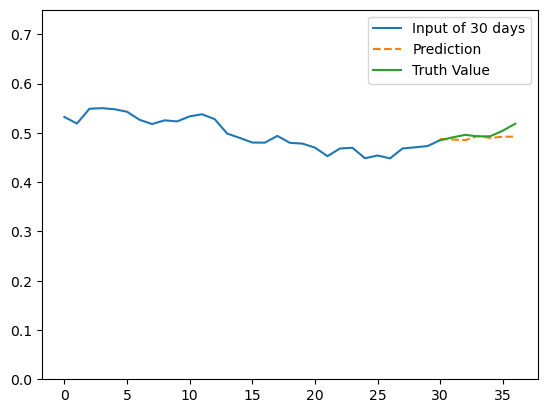

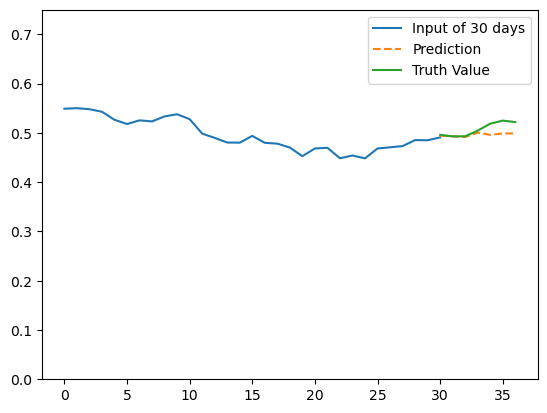

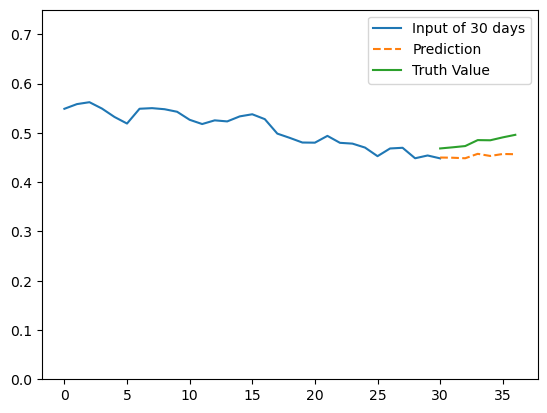

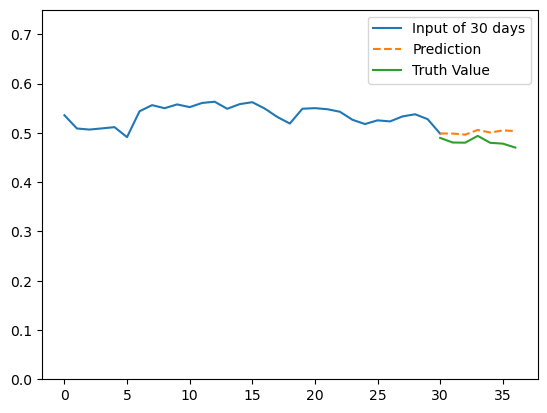

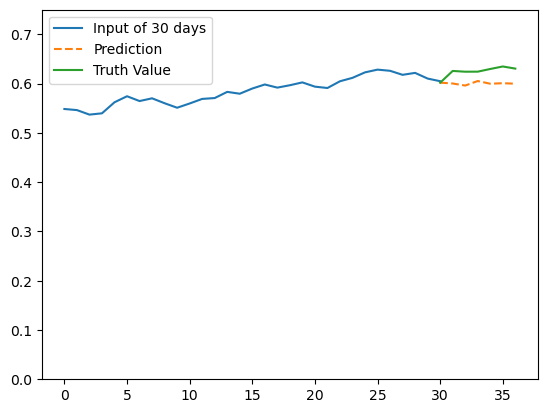

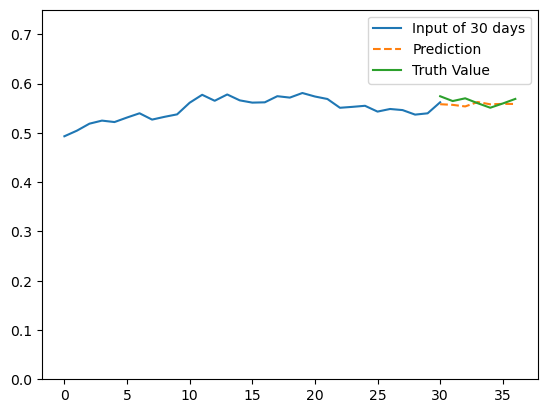

In [36]:
def visualplotloss(dataset):
    x,y = next(iter(dataset))
    output = new_model.predict(x)
    timecorr =list(range(30,37))
    for j in range(8):
        plt.ylim(0,0.75)
        plt.plot(x[j])
        plt.plot(timecorr,output[j],"--")
        plt.plot(timecorr,y[j])
        plt.legend(["Input of 30 days","Prediction","Truth Value"])
        plt.show()

visualplotloss(testbatches)

**<H2>Issues**

Model Performance is weird although the predictions are good.